# No G vs. +G slice analysis

Jupyter notebook containing analysis to look at differences in barcode dynamics in slices infected with no G or +G lentiviral helpers and barcoded RVdG.

In [1]:
import os
!pip freeze > requirements.txt

Input for this notebook requires:
1) A list of cell barcodes passing transcriptome QC for no G datasets
2) RVdG barcode matrix for no G datasts
3) 

Output for this notebook includes:
1) Histograms showing hamming distance for each bit x bit combination
2) Bar plot showing percentage of bits from diversity libraries that either don't map, map to a single bit, or are multi-mapping

Module and their versions used when generating figures for the paper can be found in 'requirements.txt', which is stored in our GitHub repository: https://github.com/MEUrbanek/rabies_barcode_tech

This code was last amended by Maddie Urbanek on 12/12/2025

## Notebook Set-up

In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [1]:
#Load in modules:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from itertools import product
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA
from tqdm.notebook import tqdm
from scipy import stats
import time

In [2]:
#Set working directory to point to barcode diversity libraries
import os
os.chdir('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/')

In [3]:
#Import no G barcodes
bc_1=pd.read_table('./fastqs/slice_experiments/no_g/no_g_1/bc/completecounts.tsv',delimiter='\t')
bc_2=pd.read_table('./fastqs/slice_experiments/no_g/no_g_2/bc/completecounts.tsv',delimiter='\t')


In [4]:
#Import no G real cells
nog_1=pd.read_table('./transcriptome/cellbarcode_lists/nog1.csv',delimiter=',')
nog_2=pd.read_table('./transcriptome/cellbarcode_lists/nog2.csv',delimiter=',')

In [5]:
#Import real, thresholded experimental barcodes
real_exp=pd.read_table('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/umi_2_processed_barcodes_df.csv',delimiter=',')

In [78]:
#Import barcode counts matrix from Patch-seqed HEK cells
#Infected
hek_1=pd.read_table('./fastqs/hekgt/hek_1/completecounts.tsv',delimiter='\t')
hek_1['CBC']='hek_1'
hek_2=pd.read_table('./fastqs/hekgt/hek_2/completecounts.tsv',delimiter='\t')
hek_2['CBC']='hek_2'
hek_3=pd.read_table('./fastqs/hekgt/hek_3/completecounts.tsv',delimiter='\t')
hek_3['CBC']='hek_3'
hek_4=pd.read_table('./fastqs/hekgt/hek_4/completecounts.tsv',delimiter='\t')
hek_4['CBC']='hek_4'
hek_5=pd.read_table('./fastqs/hekgt/hek_5/completecounts.tsv',delimiter='\t')
hek_5['CBC']='hek_5'
hek_6=pd.read_table('./fastqs/hekgt/hek_6/completecounts.tsv',delimiter='\t')
hek_6['CBC']='hek_6'
hek_7=pd.read_table('./fastqs/hekgt/hek_7/completecounts.tsv',delimiter='\t')
hek_7['CBC']='hek_7'
hek_8=pd.read_table('./fastqs/hekgt/hek_8/completecounts.tsv',delimiter='\t')
hek_8['CBC']='hek_8'
hek_9=pd.read_table('./fastqs/hekgt/hek_9/completecounts.tsv',delimiter='\t')
hek_9['CBC']='hek_9'
hek_10=pd.read_table('./fastqs/hekgt/hek_10/completecounts.tsv',delimiter='\t')
hek_10['CBC']='hek_10'
hek_11=pd.read_table('./fastqs/hekgt/hek_11/completecounts.tsv',delimiter='\t')
hek_11['CBC']='hek_11'
hek_12=pd.read_table('./fastqs/hekgt/hek_12/completecounts.tsv',delimiter='\t')
hek_12['CBC']='hek_12'
hek_13=pd.read_table('./fastqs/hekgt/hek_13/completecounts.tsv',delimiter='\t')
hek_13['CBC']='hek_13'
hek_14=pd.read_table('./fastqs/hekgt/hek_14/completecounts.tsv',delimiter='\t')
hek_14['CBC']='hek_14'
hek_15=pd.read_table('./fastqs/hekgt/hek_15/completecounts.tsv',delimiter='\t')
hek_15['CBC']='hek_15'
hek_16=pd.read_table('./fastqs/hekgt/hek_16/completecounts.tsv',delimiter='\t')
hek_16['CBC']='hek_16'

#Uninfected
uhek_1=pd.read_table('./hek_tva/uninfected/hek_1/completecounts.tsv',delimiter='\t')
uhek_1['CBC']='uhek_1'
uhek_2=pd.read_table('./hek_tva/uninfected/hek_2/completecounts.tsv',delimiter='\t')
uhek_2['CBC']='uhek_2'
uhek_3=pd.read_table('./hek_tva/uninfected/hek_3/completecounts.tsv',delimiter='\t')
uhek_3['CBC']='uhek_3'
uhek_4=pd.read_table('./hek_tva/uninfected/hek_4/completecounts.tsv',delimiter='\t')
uhek_4['CBC']='uhek_4'
uhek_5=pd.read_table('./hek_tva/uninfected/hek_5/completecounts.tsv',delimiter='\t')
uhek_5['CBC']='uhek_5'
uhek_6=pd.read_table('./hek_tva/uninfected/hek_6/completecounts.tsv',delimiter='\t')
uhek_6['CBC']='uhek_6'
uhek_7=pd.read_table('./hek_tva/uninfected/hek_7/completecounts.tsv',delimiter='\t')
uhek_7['CBC']='uhek_7'
uhek_8=pd.read_table('./hek_tva/uninfected/hek_8/completecounts.tsv',delimiter='\t')
uhek_8['CBC']='uhek_8'

In [6]:
#Look at distribution in dissociated data
#Load in rabies count matrices

    #Rabies barcode count matrices are calculated individually for each dataset using the script rvdg_barcode_calling.sh
    #These count matrices are loaded in, assigned a matching dataset ID to the transcriptome_metadata table from above, and renamed to match those cell barcodes
    #The dataset ID for each sample is also tacked onto the front of the rabies barcode sequence to prevent barcode collision across distinct slices

s1=pd.read_table('./barcode_count_matrices/s1_completecounts.tsv',delimiter='\t')
s1['datasetid']='s1'
s1['CBC'] = s1['CBC'].str.replace("'", "")
s1['CBC'] = s1['CBC'].str.replace('b', 's1_')
s1['barcode'] = 's1_' + s1['barcode']

s2=pd.read_table('./barcode_count_matrices/s2_completecounts.tsv',delimiter='\t')
s2['datasetid']='s2'
s2['CBC'] = s2['CBC'].str.replace("'", "")
s2['CBC'] = s2['CBC'].str.replace('b', 's2_')
s2['barcode'] = 's2' + s2['barcode']

s3=pd.read_table('./barcode_count_matrices/s3_completecounts.tsv',delimiter='\t')
s3['datasetid']='s3'
s3['CBC'] = s3['CBC'].str.replace("'", "")
s3['CBC'] = s3['CBC'].str.replace('b', 's3_')
s3['barcode'] = 's3_' + s3['barcode']

s4=pd.read_table('./barcode_count_matrices/s4_completecounts.tsv',delimiter='\t')
s4['datasetid']='s4'
s4['CBC'] = s4['CBC'].str.replace("'", "")
s4['CBC'] = s4['CBC'].str.replace('b', 's4_')
s4['barcode'] = 's4_' + s4['barcode']


s5=pd.read_table('./barcode_count_matrices/s5_completecounts.tsv',delimiter='\t')
s5['datasetid']='s5'
s5['CBC'] = s5['CBC'].str.replace("'", "")
s5['CBC'] = s5['CBC'].str.replace('b', 's5_')
s5['barcode'] = 's5_' + s5['barcode']


c1=pd.read_table('./barcode_count_matrices/c1_completecounts.tsv',delimiter='\t')
c1['datasetid']='c1'
c1['CBC'] = c1['CBC'].str.replace("'", "")
c1['CBC'] = c1['CBC'].str.replace('b', 'c1_')
c1['barcode'] = 'c1_' + c1['barcode']


c2=pd.read_table('./barcode_count_matrices/c2_completecounts.tsv',delimiter='\t')
c2['datasetid']='c2'
c2['CBC'] = c2['CBC'].str.replace("'", "")
c2['CBC'] = c2['CBC'].str.replace('b', 'c2_')
c2['barcode'] = 'c2_' + c2['barcode']


n1=pd.read_table('./barcode_count_matrices/n1_completecounts.tsv',delimiter='\t')
n1['datasetid']='n1'
n1['CBC'] = n1['CBC'].str.replace("'", "")
n1['CBC'] = n1['CBC'].str.replace('b', 'n1_')
n1['barcode'] = 'n1_' + n1['barcode']


n2=pd.read_table('./barcode_count_matrices/n2_completecounts.tsv',delimiter='\t')
n2['datasetid']='n2'
n2['CBC'] = n2['CBC'].str.replace("'", "")
n2['CBC'] = n2['CBC'].str.replace('b', 'n2_')
n2['barcode'] = 'n2_' + n2['barcode']


c3=pd.read_table('./barcode_count_matrices/c3_completecounts.tsv',delimiter='\t')
c3['datasetid']='c3'
c3['CBC'] = c3['CBC'].str.replace("'", "")
c3['CBC'] = c3['CBC'].str.replace('b', 'c3_')
c3['barcode'] = 'c3_' + c3['barcode']

c4=pd.read_table('./barcode_count_matrices/c4_completecounts.tsv',delimiter='\t')
c4['datasetid']='c4'
c4['CBC'] = c4['CBC'].str.replace("'", "")
c4['CBC'] = c4['CBC'].str.replace('b', 'c4_')
c4['barcode'] = 'c4_' + c4['barcode']

n3=pd.read_table('./barcode_count_matrices/n3_completecounts.tsv',delimiter='\t')
n3['datasetid']='n3'
n3['CBC'] = n3['CBC'].str.replace("'", "")
n3['CBC'] = n3['CBC'].str.replace('b', 'n3_')
n3['barcode'] = 'n3_' + n3['barcode']

n4=pd.read_table('./barcode_count_matrices/n4_completecounts.tsv',delimiter='\t')
n4['datasetid']='n4'
n4['CBC'] = n4['CBC'].str.replace("'", "")
n4['CBC'] = n4['CBC'].str.replace('b', 'n4_')
n4['barcode'] = 'n4_' + n4['barcode']


In [7]:
#THIS IS POINTING TO LOG1P FIRST NORMALIZATION
#metadata_df=pd.read_csv('./transcriptome/filtered_assignments.csv')
#THIS IS THE ONE I GENERATED WITH THE FIXED REFERENCE ATLAS ON SEP 30!!!

#THIS ONE IS WITH IKE'S CODE
metadata_df=pd.read_csv('./transcriptome/mapped_centroids.csv')
metadata_df=metadata_df.loc[metadata_df['high_score'] >0.2]
metadata_df = metadata_df.rename(columns={'type_updated': 'celltype', 'Unnamed: 0':'cellbarcode','dataset_id':'datasetid'})
metadata_df

,cellbarcode,high_score,datasetid,cbc,celltype,n_types,umap_1,umap_2
0,c1_AAAAAAAAATCGCAGA,0.416132,c1,CVS-N2c cell,EN-L4-IT,1,-4.291120,-1.398332
1,c1_AAAAAAACCCTCCCAA,0.551036,c1,CVS-N2c cell,EN-L4-IT,1,-6.856859,-1.405619
2,c1_AAAAAACAAGCTAAGC,0.541680,c1,CVS-N2c cell,EN-L4-IT,1,-5.705260,0.020503
3,c1_AAAAAAGCATGGAGGT,0.490021,c1,CVS-N2c cell,EN-L4-IT,1,-6.399585,-1.293094
4,c1_AAAAAAGTAGATCAAA,0.458501,c1,CVS-N2c cell,Astrocyte-Fibrous,1,10.384505,3.936133
...,...,...,...,...,...,...,...,...
49549,s1_CCTCCCCCAGCGATCC,0.434926,s1,SADB-19 cell,IPC-EN,1,1.393792,-0.107803
49550,s1_CCTGAGAAACCGACGC,0.457192,s1,SADB-19 cell,EN-Newborn,1,-1.639336,-2.168794
49551,s1_CCTGCCCGATGTAATT,0.484928,s1,SADB-19 cell,RG-vRG,1,10.178526,3.639504
49552,s1_CCTTATTGCATTCCCA,0.529649,s1,SADB-19 cell,EN-Newborn,1,-0.411113,-1.457353


In [8]:
#Empty droplets
empty_droplets=pd.read_table('./connectivity/empty_droplet_bcs.csv',delimiter=',')
empty_droplets

,Unnamed: 0,CBC,barcode,UMI_Count,datasetid
0,43,c1_ATCTCAAACATCAGGA,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
1,76,c1_ACCTAAGTCCTTCATA,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
2,94,c1_CCATCCGGAGGGAACG,c1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...,1,c1
3,107,c1_AACTATGCAGTAAATA,c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...,5,c1
4,111,c1_ATAGCAATATAGCATG,c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...,1,c1
...,...,...,...,...,...
645920,29564783,n4_ACAGAATCCATTCAAC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
645921,29564908,n4_ACAGAGATACATCAAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
645922,29564918,n4_CCACCCTTCCGAAAAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
645923,29564921,n4_AGAGCAATCACGACGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTTTGCGCGAGTCACTG-...,1,n4


In [9]:
bc_1['CBC'] = bc_1['CBC'].str.replace("'", "")
bc_1['CBC'] = bc_1['CBC'].str.replace('b', 'nog1_')

bc_2['CBC'] = bc_2['CBC'].str.replace("'", "")
bc_2['CBC'] = bc_2['CBC'].str.replace('b', 'nog2_')

real_bc_1 = bc_1.loc[bc_1['CBC'].isin(nog_1['x'])]
real_bc_2 = bc_2.loc[bc_2['CBC'].isin(nog_2['x'])]

print("Number of real cells in dataset 1:")
print(real_bc_1['CBC'].nunique())

print()
print("Number of real cells in dataset 2:")
print(real_bc_2['CBC'].nunique())   

Number of real cells in dataset 1:
625

Number of real cells in dataset 2:
2929


In [10]:
#Remove any cells mapping to 'unknown' or low-number clusters
metadata_df.drop(metadata_df[metadata_df['celltype'] == 'Unknown'].index, inplace=True)
metadata_df

,cellbarcode,high_score,datasetid,cbc,celltype,n_types,umap_1,umap_2
0,c1_AAAAAAAAATCGCAGA,0.416132,c1,CVS-N2c cell,EN-L4-IT,1,-4.291120,-1.398332
1,c1_AAAAAAACCCTCCCAA,0.551036,c1,CVS-N2c cell,EN-L4-IT,1,-6.856859,-1.405619
2,c1_AAAAAACAAGCTAAGC,0.541680,c1,CVS-N2c cell,EN-L4-IT,1,-5.705260,0.020503
3,c1_AAAAAAGCATGGAGGT,0.490021,c1,CVS-N2c cell,EN-L4-IT,1,-6.399585,-1.293094
4,c1_AAAAAAGTAGATCAAA,0.458501,c1,CVS-N2c cell,Astrocyte-Fibrous,1,10.384505,3.936133
...,...,...,...,...,...,...,...,...
49549,s1_CCTCCCCCAGCGATCC,0.434926,s1,SADB-19 cell,IPC-EN,1,1.393792,-0.107803
49550,s1_CCTGAGAAACCGACGC,0.457192,s1,SADB-19 cell,EN-Newborn,1,-1.639336,-2.168794
49551,s1_CCTGCCCGATGTAATT,0.484928,s1,SADB-19 cell,RG-vRG,1,10.178526,3.639504
49552,s1_CCTTATTGCATTCCCA,0.529649,s1,SADB-19 cell,EN-Newborn,1,-0.411113,-1.457353


In [11]:
#Drop any barcodes that don't map to cells passing transcriptome QC
s1 = s1.loc[s1['CBC'].isin(metadata_df['cellbarcode'])].copy()
s2 = s2.loc[s2['CBC'].isin(metadata_df['cellbarcode'])].copy()
s3 = s3.loc[s3['CBC'].isin(metadata_df['cellbarcode'])].copy()
s4 = s4.loc[s4['CBC'].isin(metadata_df['cellbarcode'])].copy()
s5 = s5.loc[s5['CBC'].isin(metadata_df['cellbarcode'])].copy()

c1 = c1.loc[c1['CBC'].isin(metadata_df['cellbarcode'])].copy()
c2 = c2.loc[c2['CBC'].isin(metadata_df['cellbarcode'])].copy()
c3 = c3.loc[c3['CBC'].isin(metadata_df['cellbarcode'])].copy()
c4 = c4.loc[c4['CBC'].isin(metadata_df['cellbarcode'])].copy()

n1 = n1.loc[n1['CBC'].isin(metadata_df['cellbarcode'])].copy()
n2 = n2.loc[n2['CBC'].isin(metadata_df['cellbarcode'])].copy()
n3 = n3.loc[n3['CBC'].isin(metadata_df['cellbarcode'])].copy()
n4 = n4.loc[n4['CBC'].isin(metadata_df['cellbarcode'])].copy()

In [91]:
#Downsample empty droplet barcode dataframe to 10,000 cells and 10,000 nuclei for streamlined plotting
empty_cell= empty_droplets.loc[empty_droplets['datasetid'].isin(['c1','c2','c3','c4'])]
empty_nuc= empty_droplets.loc[empty_droplets['datasetid'].isin(['n1','n2','n3','n4'])]
downsampled_empty_cell = empty_cell.sample(n=10000, random_state=13)
downsampled_empty_nuc = empty_nuc.sample(n=10000, random_state=13)

In [92]:
def make_unique_table(dataset,datasetid
                     ):
        temp=pd.DataFrame(dataset.groupby('CBC')['barcode'].nunique())
        temp['datasetid']=datasetid
        return temp

In [93]:
s1_unique=make_unique_table(s1,'s1')
s2_unique=make_unique_table(s2,'s2')
s3_unique=make_unique_table(s3,'s3')
s4_unique=make_unique_table(s4,'s4')
s5_unique=make_unique_table(s5,'s5')

c1_unique=make_unique_table(c1,'c1')
c2_unique=make_unique_table(c2,'c2')
c3_unique=make_unique_table(c3,'c3')
c4_unique=make_unique_table(c4,'c4')

n1_unique=make_unique_table(n1,'n1')
n2_unique=make_unique_table(n2,'n2')
n3_unique=make_unique_table(n3,'n3')
n4_unique=make_unique_table(n4,'n4')

empty_nuc_unique=make_unique_table(downsampled_empty_nuc,'empty_nuc')
empty_cell_unique=make_unique_table(downsampled_empty_cell,'empty_cell')

nog1_unique=make_unique_table(real_bc_1,'no_g')
nog2_unique=make_unique_table(real_bc_2,'no_g')

hek=pd.concat([hek_1,
               hek_2,
               hek_3,
               hek_4,
               hek_5,
               hek_6,
               hek_7,
               hek_8,
               hek_9,
               hek_10,
               hek_11,
               hek_12,
               hek_13,
               hek_14,
               hek_15,
               hek_16
              ])

uhek=pd.concat([uhek_1,
               uhek_2,
               uhek_3,
               uhek_4,
               uhek_5,
               uhek_6,
               uhek_7,
               uhek_8
              ])
              
hek_unique=make_unique_table(hek,'hek')
uhek_unique=make_unique_table(uhek,'uhek')            

In [94]:
#Concatenate all dataframes together for input into box and whisker plot
box_input=pd.concat([s1_unique,
                     s2_unique,
                     s3_unique,
                     s4_unique,
                     s5_unique,
                     c1_unique,
                     c2_unique,
                     c3_unique,
                     c4_unique,
                     n1_unique,
                     n2_unique,
                     n3_unique,
                     n4_unique,
                     nog1_unique,
                     nog2_unique,
                     empty_cell_unique,
                     empty_nuc_unique,
                     hek_unique,
                     uhek_unique
                    ])

box_input

,barcode,datasetid
CBC,,
s1_AAAAAAGGCCTCATCA,228,s1
s1_AAAAAATGAGATAGTT,92,s1
s1_AAAAAGCGATTGAGCA,271,s1
s1_AAAAAGTGAGAGACGC,105,s1
s1_AAAACCAGAGGTATTA,53,s1
...,...,...
uhek_4,224,uhek
uhek_5,1056,uhek
uhek_6,1031,uhek


In [95]:
box_input['logged_values']=np.log10(box_input['barcode'])
box_input

,barcode,datasetid,logged_values
CBC,,,
s1_AAAAAAGGCCTCATCA,228,s1,2.357935
s1_AAAAAATGAGATAGTT,92,s1,1.963788
s1_AAAAAGCGATTGAGCA,271,s1,2.432969
s1_AAAAAGTGAGAGACGC,105,s1,2.021189
s1_AAAACCAGAGGTATTA,53,s1,1.724276
...,...,...,...
uhek_4,224,uhek,2.350248
uhek_5,1056,uhek,3.023664
uhek_6,1031,uhek,3.013259


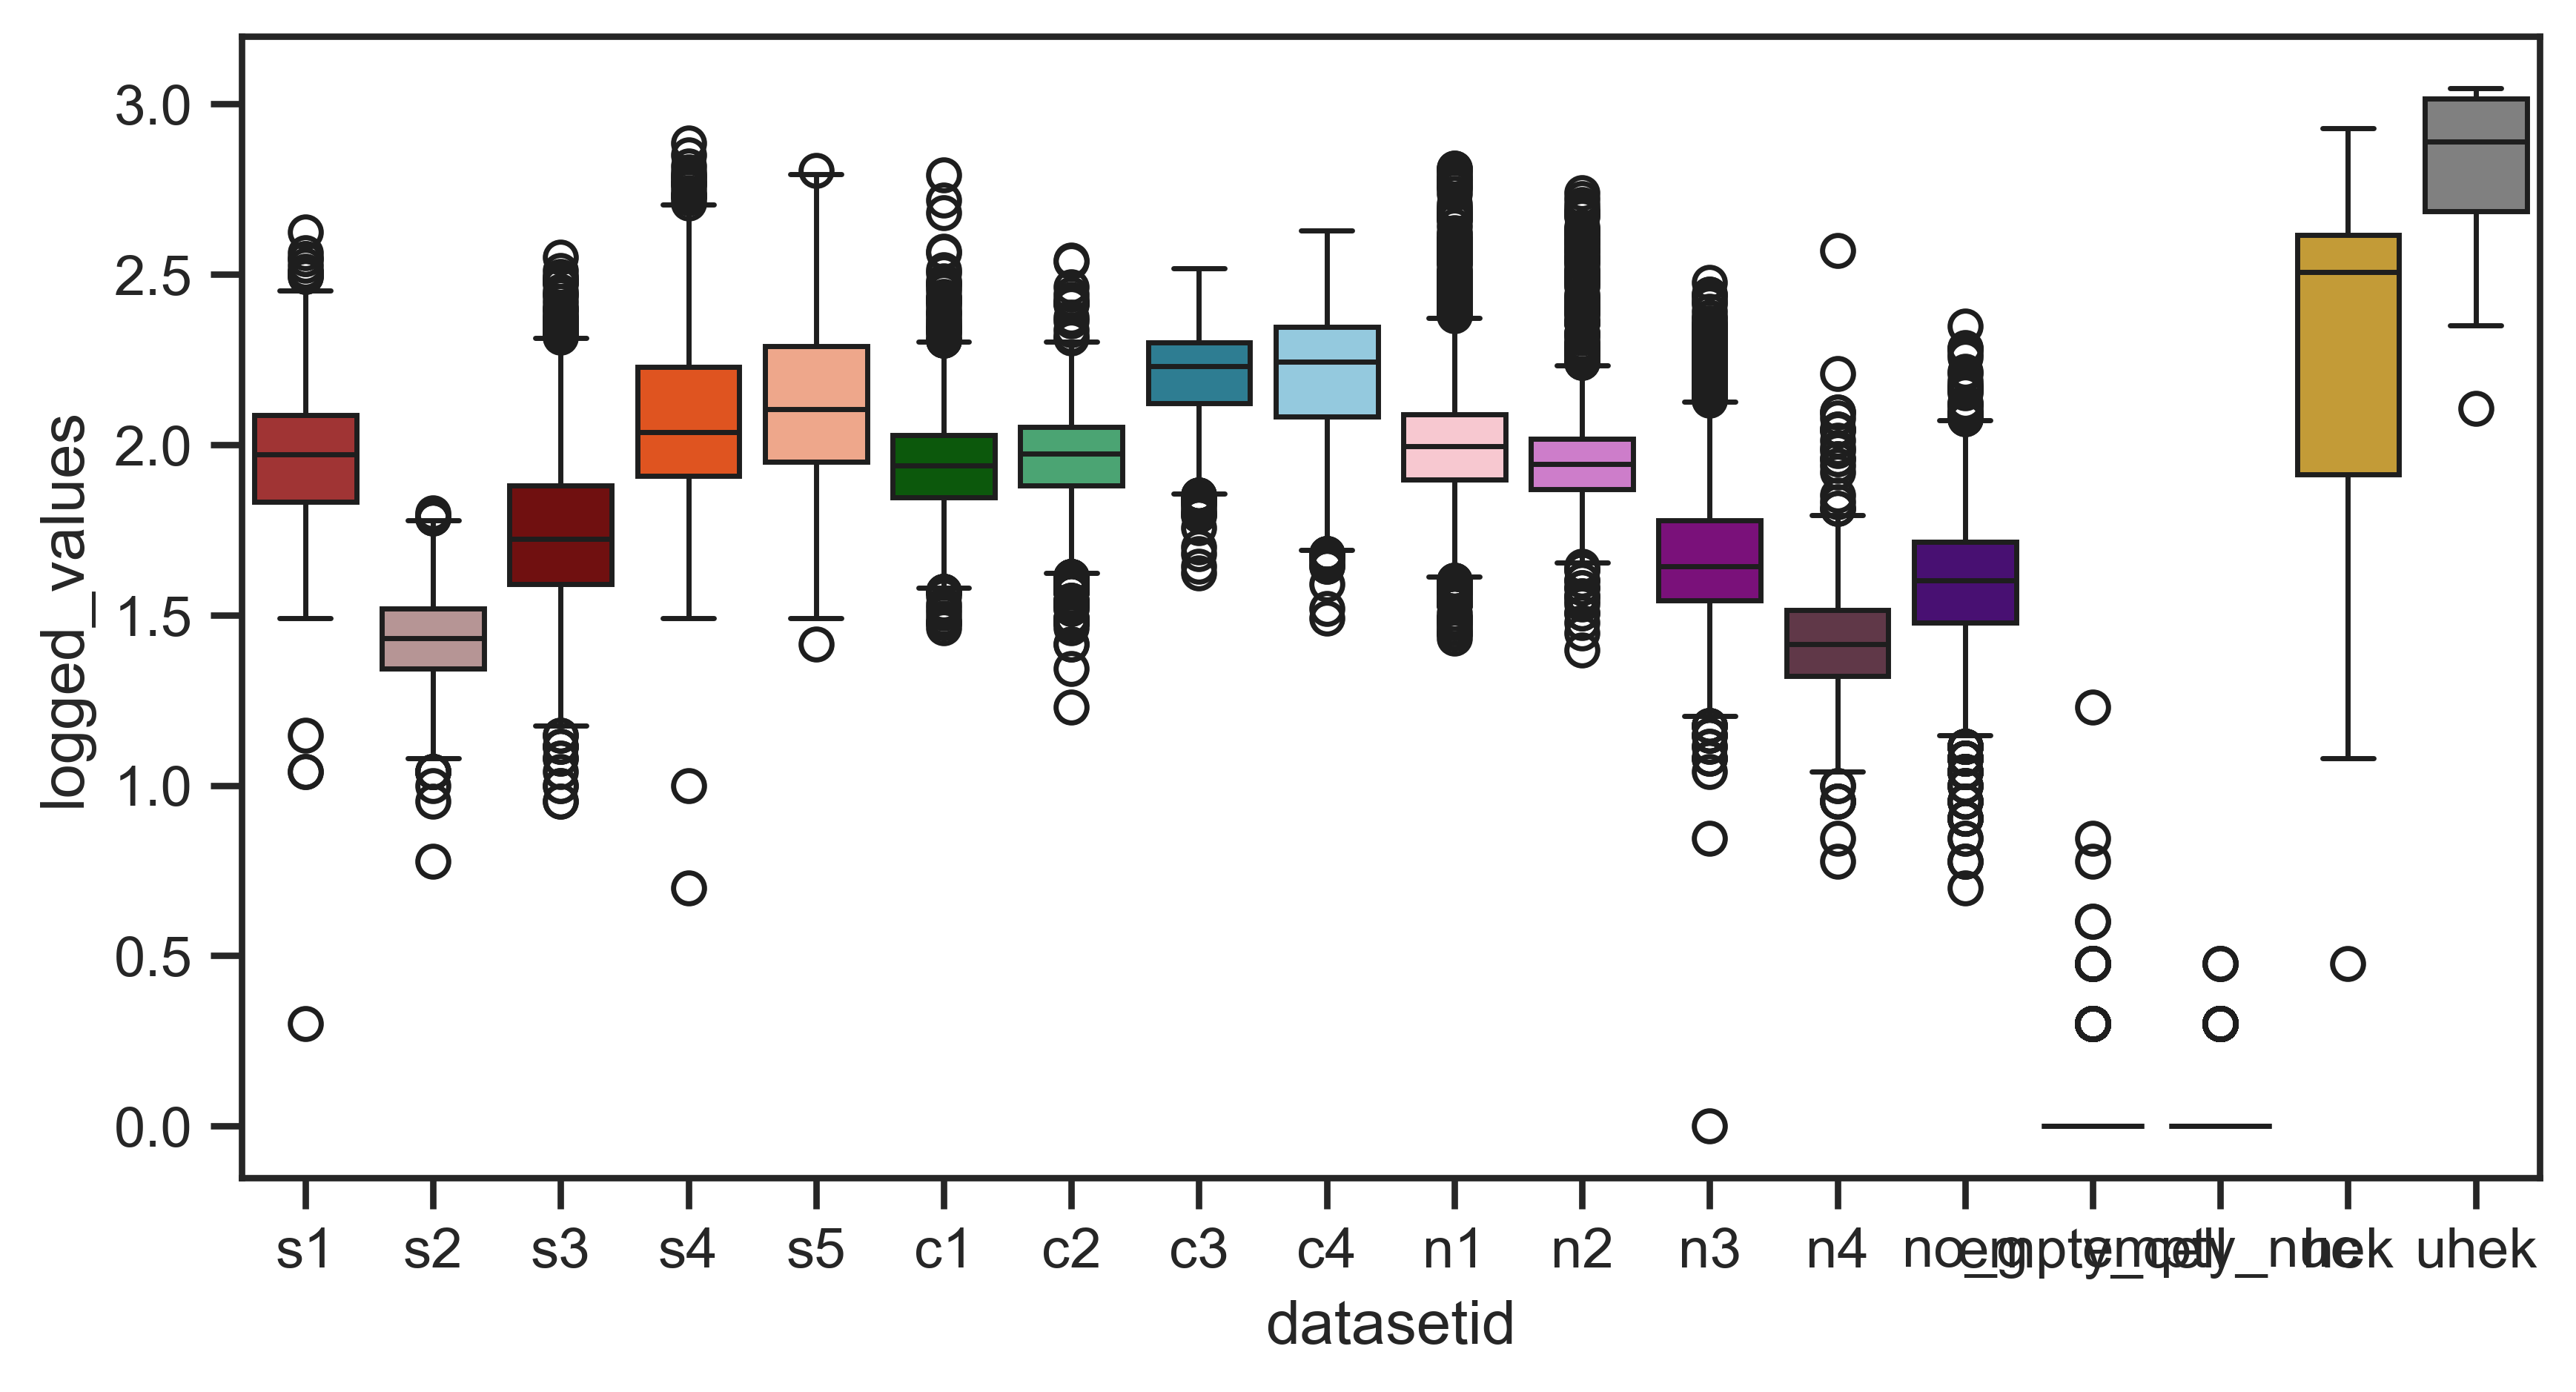

In [97]:
from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=500)


custom_params = {"axes.spines.right": True, "axes.spines.top": True}

sns.set_theme(context='notebook', style='ticks', palette='deep', font='arial', font_scale=1, color_codes=True, rc=custom_params)
palette = ["#b22222","#bc8f8f",'#800000','#ff4500','#ffa07a',
           '#006400','#3cb371','#1d87a3','#87ceeb',
           '#ffc0cb','#da70d6','#8b008b','#673147',
          'indigo',
          '#816482','#5f668e',
          'goldenrod','grey']
sns.set_palette(palette)
sns.boxplot(data=box_input, x="datasetid", y="logged_values", hue="datasetid")
plt.legend([],[], frameon=False)
plt.savefig('../figs/sfig_conn/unique_bcs_by_dataset.pdf', bbox_inches='tight', format='pdf')

In [98]:
cell=pd.concat([s1_unique,
                s2_unique,
                s3_unique,
                s4_unique,
                s5_unique,
                c1_unique,
                c2_unique,
                c3_unique,
                c4_unique])
nuc=pd.concat([n1_unique,
                n2_unique,
                n3_unique,
                n4_unique])
nuc

,barcode,datasetid
CBC,,
n1_AAAAAAATATGTAGCC,61,n1
n1_AAAAAATACCAAAATG,120,n1
n1_AAAAAATCCCTGAGAA,119,n1
n1_AAAAAATGAGGCAATG,144,n1
n1_AAAAAATGATGGAGCA,111,n1
...,...,...
n4_CCTTACGGACAAAAGG,36,n4
n4_CCTTATGCACTCAGGC,31,n4
n4_CCTTCAGTCACTAAGG,37,n4


In [99]:
print(nuc['barcode'].median())
print(nuc['barcode'].mean())

print(cell['barcode'].median())
print(cell['barcode'].mean())

72.0
81.55247834114472
91.0
100.75628815628815


In [ ]:
# %UMI plots

### W/ thresholding

In [12]:
#For dataset 1:
real_bc_1.drop(real_bc_1[real_bc_1['UMI_Count'] < 2].index, inplace=True)
print("Dataset 1:")
print("Total number of infection events:")
print(len(real_bc_1))
print("Unique barcodes in dataset:")
print(real_bc_1['barcode'].nunique())


#For dataset 2:
real_bc_2.drop(real_bc_2[real_bc_2['UMI_Count'] < 2].index, inplace=True)
print("Dataset 2:")
print("Total number of infection events:")
print(len(real_bc_2))
print("Unique barcodes in dataset:")
print(real_bc_2['barcode'].nunique())



Dataset 1:
Total number of infection events:
2183
Unique barcodes in dataset:
1137
Dataset 2:
Total number of infection events:
9835
Unique barcodes in dataset:
7100


/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_78776/1704686249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bc_1.drop(real_bc_1[real_bc_1['UMI_Count'] < 2].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_78776/1704686249.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bc_2.drop(real_bc_2[real_bc_2['UMI_Count'] < 2].index, inplace=True)


In [13]:
#Get proportions for each barcode
#Viral diversity libraries are generated from sequencing the rabies genome
#Because they are the reverse complement of the sequences derived from polyA capture with Pip-seq,
#We need to make a bit key that allows us to switch between strands of barcode sequences

#The resulting dataframe is derived from our bit sequences and should have four columns
    #original=barcode number, forward orientation
    #reverse=barcode number, reverse orientation
    #original_seq=barcode sequence, forward orientation
    #reverse_seq=barcide sequence, reverse orientation

remapping_bits=pd.read_table('/Users/maddieurbanek/Desktop/revision_data/remapping_bits.csv',delimiter=',',header=None)
remapping_bits.columns=['original','reverse']
remapping_bits['original']=remapping_bits['original'].str.replace(">","")
remapping_bits['reverse']=remapping_bits['reverse'].str.replace(">","")

fragments = remapping_bits.iloc[::2]
bits = remapping_bits.iloc[1::2]
bit_key = pd.concat([fragments, bits.set_index(fragments.index)], axis = 1)
bit_key.columns=['original','reverse','original_seq','reverse_seq']

#Set original forward indexing as key
original_key=bit_key.set_index('original')
original_key

,reverse,original_seq,reverse_seq
original,,,
Fragment1_F_001,Fragment1_R_001,AATTCCATAGGGGCACAGCCG,GATCCGGCTGTGCCCCTATGG
Fragment1_F_002,Fragment1_R_002,AATTCCGATTCACATAGGGGG,GATCCCCCCTATGTGAATCGG
Fragment1_F_003,Fragment1_R_003,AATTCGCAACAATGCGCTGTG,GATCCACAGCGCATTGTTGCG
Fragment1_F_004,Fragment1_R_004,AATTCTGATGGAGTGTGTGGG,GATCCCCACACACTCCATCAG
Fragment1_F_005,Fragment1_R_005,AATTCATGTCGGATTCCGGTG,GATCCACCGGAATCCGACATG
...,...,...,...
Fragment3_F_496,Fragment3_R_496,CTAGCGCGGGCATTCAGAAC,TCGAGTTCTGAATGCCCGCG
Fragment3_F_497,Fragment3_R_497,CTAGGAGTCGCTTGTGCGTC,TCGAGACGCACAAGCGACTC
Fragment3_F_498,Fragment3_R_498,CTAGTAACGGACGGGTTGTC,TCGAGACAACCCGTCCGTTA


In [14]:
#For March 2024, CVS libraries
mar2024_cvs=pd.read_table('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/barcode_diversity_libraries/used_in_experiments/cvs_rep.csv',delimiter=',')
mar2024_cvs=mar2024_cvs[['barcode','UMI_Count']]
mar2024_cvs.columns=['viral_barcode','viral_total_UMIs']

#Add metrics barcode proportions and rank barcodes by prevalence
mar2024_cvs['%UMI']=(mar2024_cvs['viral_total_UMIs']/(mar2024_cvs['viral_total_UMIs'].sum()))*100
mar2024_cvs_s=mar2024_cvs.sort_values(by='%UMI',ascending=False)
mar2024_cvs=mar2024_cvs_s.reset_index()
mar2024_cvs['rank']=mar2024_cvs.index

#Formatting
mar2024_cvs[['bit1', 'bit2', 'bit3']] = mar2024_cvs['viral_barcode'].str.split('-', expand=True)
mar2024_cvs['original_bit3'] = mar2024_cvs['bit1'].map(remapping_bits.set_index('reverse')['original'])
mar2024_cvs['original_bit2'] = mar2024_cvs['bit2'].map(remapping_bits.set_index('reverse')['original'])
mar2024_cvs['original_bit1'] = mar2024_cvs['bit3'].map(remapping_bits.set_index('reverse')['original'])
mar2024_cvs['original_barcode']=mar2024_cvs['original_bit1'] + "-" + mar2024_cvs['original_bit2'] + "-" + mar2024_cvs['original_bit3']

#Expand library
exp_mar2024_cvs=mar2024_cvs['original_barcode'].repeat(mar2024_cvs['viral_total_UMIs'])
exp_mar2024_cvs=pd.DataFrame(exp_mar2024_cvs)
exp_mar2024_cvs=exp_mar2024_cvs.reset_index()
exp_mar2024_cvs

,index,original_barcode
0,0,AATTCTTTGGCGGGACGTGTG-GATCAGCTGAGTTTGCCAGG-CTA...
1,0,AATTCTTTGGCGGGACGTGTG-GATCAGCTGAGTTTGCCAGG-CTA...
2,0,AATTCTTTGGCGGGACGTGTG-GATCAGCTGAGTTTGCCAGG-CTA...
3,0,AATTCTTTGGCGGGACGTGTG-GATCAGCTGAGTTTGCCAGG-CTA...
4,0,AATTCTTTGGCGGGACGTGTG-GATCAGCTGAGTTTGCCAGG-CTA...
...,...,...
77325290,1026627,AATTCCGCTCCAGAGACAAAG-GATCGCACAGTGATGGGCAG-CTA...
77325291,1026628,AATTCACGAGCAGCAAGGAGG-GATCAGAACGGTGTGCGCAG-CTA...
77325292,1026629,AATTCGGACTGCCGTAATACG-GATCGTCGGAGTTGACGCGG-CTA...
77325293,1026630,AATTCAGCCGATAGCCTCATG-GATCAATGCATCCAGGGCGG-CTA...


In [15]:
#Build SBARRO function
#Arguments:
    #sample_dataset=barcode count matrix of transcriptome-passing, UMI thresholded cells
    #viral_library=diversity library that matchces the rabies used to infect the slice, expanded for
    #line per barcode UMI
    #bootstraps=number of iterations for infection simulations

    #This function calculates the total number of draws from the viral barcode library needed to match
    #the total number of unique barcodes observed in at least 2 cells in each experiment 
def calculate_fi_trust(sample_dataset, viral_library, bootstraps):
    starttime = time.time()
    print('Calculating Founder Infection Trust Threshold')
    #Get total number of unique barcodes observed in the slice
    dup_counts=sample_dataset['barcode'].value_counts().reset_index()
    dup_counts.drop(dup_counts[dup_counts['count'] < 2].index, inplace=True)
    total_obs_bc=dup_counts['barcode'].nunique()
    print('Total number of unique barcodes detected in ≥2 cells per slice:')
    print(total_obs_bc)
    #Make dataframe to store pulled viral barcodes from simulation
    
    print('Beginning VBC draws')
    #Make empty array to send FI trust bootstrapped values for calculating median
    fi_trust=[]

    #Bootstrap FI trust score by simulating barcode draws until the same amount of unique barcodes as observed n the original dataset are found 
    for i in range(0, bootstraps):
        exit_signal = 0
        pulled_vbc=pd.DataFrame(columns=['original_barcode'])
        while exit_signal !=1 :
            acquired_vbc=(np.random.choice(viral_library['original_barcode'],1,replace=True))
            acquired_vbc=pd.DataFrame(acquired_vbc)
            #acquired_vbc.reset_index()
            acquired_vbc.columns=['original_barcode']
            pulled_vbc=pd.concat([pulled_vbc,acquired_vbc],ignore_index=True,axis=0)
            if pulled_vbc['original_barcode'].nunique()<total_obs_bc:
                exit_signal=0
            else:
                fi_rep=len(pulled_vbc)
                fi_trust = np.append(fi_trust, fi_rep)
                exit_signal = 1
    
    print('Done calculating FI Trust Threshold! :)')
    print(fi_trust)
    fi_trust_score=np.median(fi_trust)
    print('FI Trust Threshold=')
    print(fi_trust_score)
    print()
    print('This took...')
    endtime = time.time()
    print(endtime-starttime)
    print('seconds!')
    print()
    
    return fi_trust_score

In [16]:
np.random.seed(13)

t_nog1_fi_trust=calculate_fi_trust(real_bc_1, exp_mar2024_cvs, 10)
t_nog2_fi_trust=calculate_fi_trust(real_bc_2, exp_mar2024_cvs, 10)

Calculating Founder Infection Trust Threshold
Total number of unique barcodes detected in ≥2 cells per slice:
298
Beginning VBC draws
Done calculating FI Trust Threshold! :)
[298. 299. 298. 299. 298. 298. 299. 298. 299. 301.]
FI Trust Threshold=
298.5

This took...
0.4942619800567627
seconds!

Calculating Founder Infection Trust Threshold
Total number of unique barcodes detected in ≥2 cells per slice:
1199
Beginning VBC draws
Done calculating FI Trust Threshold! :)
[1208. 1212. 1211. 1217. 1212. 1212. 1209. 1204. 1210. 1213.]
FI Trust Threshold=
1211.5

This took...
2.81086802482605
seconds!



In [17]:
#March 2024, CVS
mar2024_cvs['vbc_proportion']=mar2024_cvs['viral_total_UMIs']/(mar2024_cvs['viral_total_UMIs'].sum())
mar2024_cvs['p = 0.9'] = np.log10(0.9)/(np.log10(1-mar2024_cvs['vbc_proportion']))
mar2024_cvs['p = 0.925'] = np.log10(0.925)/(np.log10(1-mar2024_cvs['vbc_proportion']))
mar2024_cvs['p = 0.95'] = np.log10(0.95)/(np.log10(1-mar2024_cvs['vbc_proportion']))
mar2024_cvs['p = 0.975'] = np.log10(0.975)/(np.log10(1-mar2024_cvs['vbc_proportion']))
mar2024_cvs['p = 0.99'] = np.log10(0.99)/(np.log10(1-mar2024_cvs['vbc_proportion']))

In [18]:
#Make function for thresholding fi trust score by dataset
#Experimental library should be 

#Start by printing the total number of unique barcodes in the dataset
#So throw out any barcodes that fall below threshold point...threshold point comes from c1_fi_trust
#Pull all viral_library['original_barcode'] where p column > threshold
#Retain all barcodes from experimental library that are found in the original barcode list
#Return fi_thresholded dataframe
#Report back how many barcodes were lost to thresholding


def threshold_fi_trust(experimental_library, experimental_trust_score, p, viral_library):
    print('Thresholding experimental dataset based on FI trust scores')
    print('Total number of unique barcodes from experimental dataset:')
    print(experimental_library['barcode'].nunique())
    print(f'Thresholding on p = {p}')

    #Make new column in experimental library that includes barcode w/o dataset it
    experimental_library['barcode_no_id']=experimental_library['barcode'].str[3:]
    
    #Make list of barcodes that aren't meeting the threshold (lower FI trust score than experimental simulation)
    threshold_viral=viral_library[['original_barcode',f'p = {p}']]
    threshold_viral.drop(threshold_viral[threshold_viral[f'p = {p}'] > experimental_trust_score].index, inplace=True)

    thresholded_library=experimental_library.loc[~(experimental_library['barcode_no_id'].isin(threshold_viral['original_barcode']))]

    print('Total number of unique barcodes retained after thresholding on FI trust scores:')
    print(thresholded_library['barcode'].nunique())
    print('Percentage of barcodes retained:')
    print(thresholded_library['barcode'].nunique()/experimental_library['barcode'].nunique()*100)

    return thresholded_library

In [19]:
#Run FI Trust thresholding function from above
sbarro_threshold=0.95

#No G datasets 
real_bc_1=threshold_fi_trust(real_bc_1, t_nog1_fi_trust, sbarro_threshold, mar2024_cvs)
real_bc_2=threshold_fi_trust(real_bc_2, t_nog2_fi_trust, sbarro_threshold, mar2024_cvs)

Thresholding experimental dataset based on FI trust scores
Total number of unique barcodes from experimental dataset:
1137
Thresholding on p = 0.95
Total number of unique barcodes retained after thresholding on FI trust scores:
1137
Percentage of barcodes retained:
100.0
Thresholding experimental dataset based on FI trust scores
Total number of unique barcodes from experimental dataset:
7100
Thresholding on p = 0.95
Total number of unique barcodes retained after thresholding on FI trust scores:
7100
Percentage of barcodes retained:
100.0


/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_78776/3992166513.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experimental_library['barcode_no_id']=experimental_library['barcode'].str[3:]
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_78776/3992166513.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threshold_viral.drop(threshold_viral[threshold_viral[f'p = {p}'] > experimental_trust_score].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_78776/3992166513.py:19: SettingWithCopyWarning: 
A value is 

In [28]:
real_bc_1[['datasetid']]='nog'
real_bc_2[['datasetid']]='nog'

In [29]:
no_g=pd.concat([real_bc_1, real_bc_2])

In [30]:
no_g_unique=pd.DataFrame(no_g.groupby('CBC')['barcode'].nunique())
real_unique=pd.DataFrame(real_exp.groupby('CBC')['barcode'].nunique())

In [31]:
no_g_umis=pd.DataFrame(no_g.groupby('CBC')['UMI_Count'].sum())
real_umis=pd.DataFrame(real_exp.groupby('CBC')['UMI_Count'].sum())
real_umis

,UMI_Count
CBC,
c1_AAAAAAAAATCGCAGA,11
c1_AAAAAAACCCTCCCAA,16
c1_AAAAAACAAGCTAAGC,13
c1_AAAAAAGCATGGAGGT,64
c1_AAAAAAGTAGATCAAA,41
...,...
s5_CCTGAATCACGCACGG,90
s5_CCTGAATGACAACATC,1426
s5_CCTGAATTCCCTACAT,29


In [32]:
logged_nog=np.log10(no_g_umis['UMI_Count'])
logged_umis=np.log10(real_umis['UMI_Count'])

In [33]:
logged_nog=pd.DataFrame(np.log10(no_g_umis['UMI_Count']))
logged_umis=pd.DataFrame(np.log10(real_umis['UMI_Count']))

In [34]:
logged_nog = logged_nog.rename(columns={'UMI_Count': 'total'})
logged_umis = logged_umis.rename(columns={'UMI_Count': 'total'})

In [35]:
nog_mergeddf = pd.concat([logged_nog, no_g_unique],axis=1)
real_mergeddf = pd.concat([logged_umis, real_unique],axis=1)
real_mergeddf

,total,barcode
CBC,,
c1_AAAAAAAAATCGCAGA,1.041393,5
c1_AAAAAAACCCTCCCAA,1.204120,4
c1_AAAAAACAAGCTAAGC,1.113943,6
c1_AAAAAAGCATGGAGGT,1.806180,17
c1_AAAAAAGTAGATCAAA,1.612784,12
...,...,...
s5_CCTGAATCACGCACGG,1.954243,33
s5_CCTGAATGACAACATC,3.154120,148
s5_CCTGAATTCCCTACAT,1.462398,12


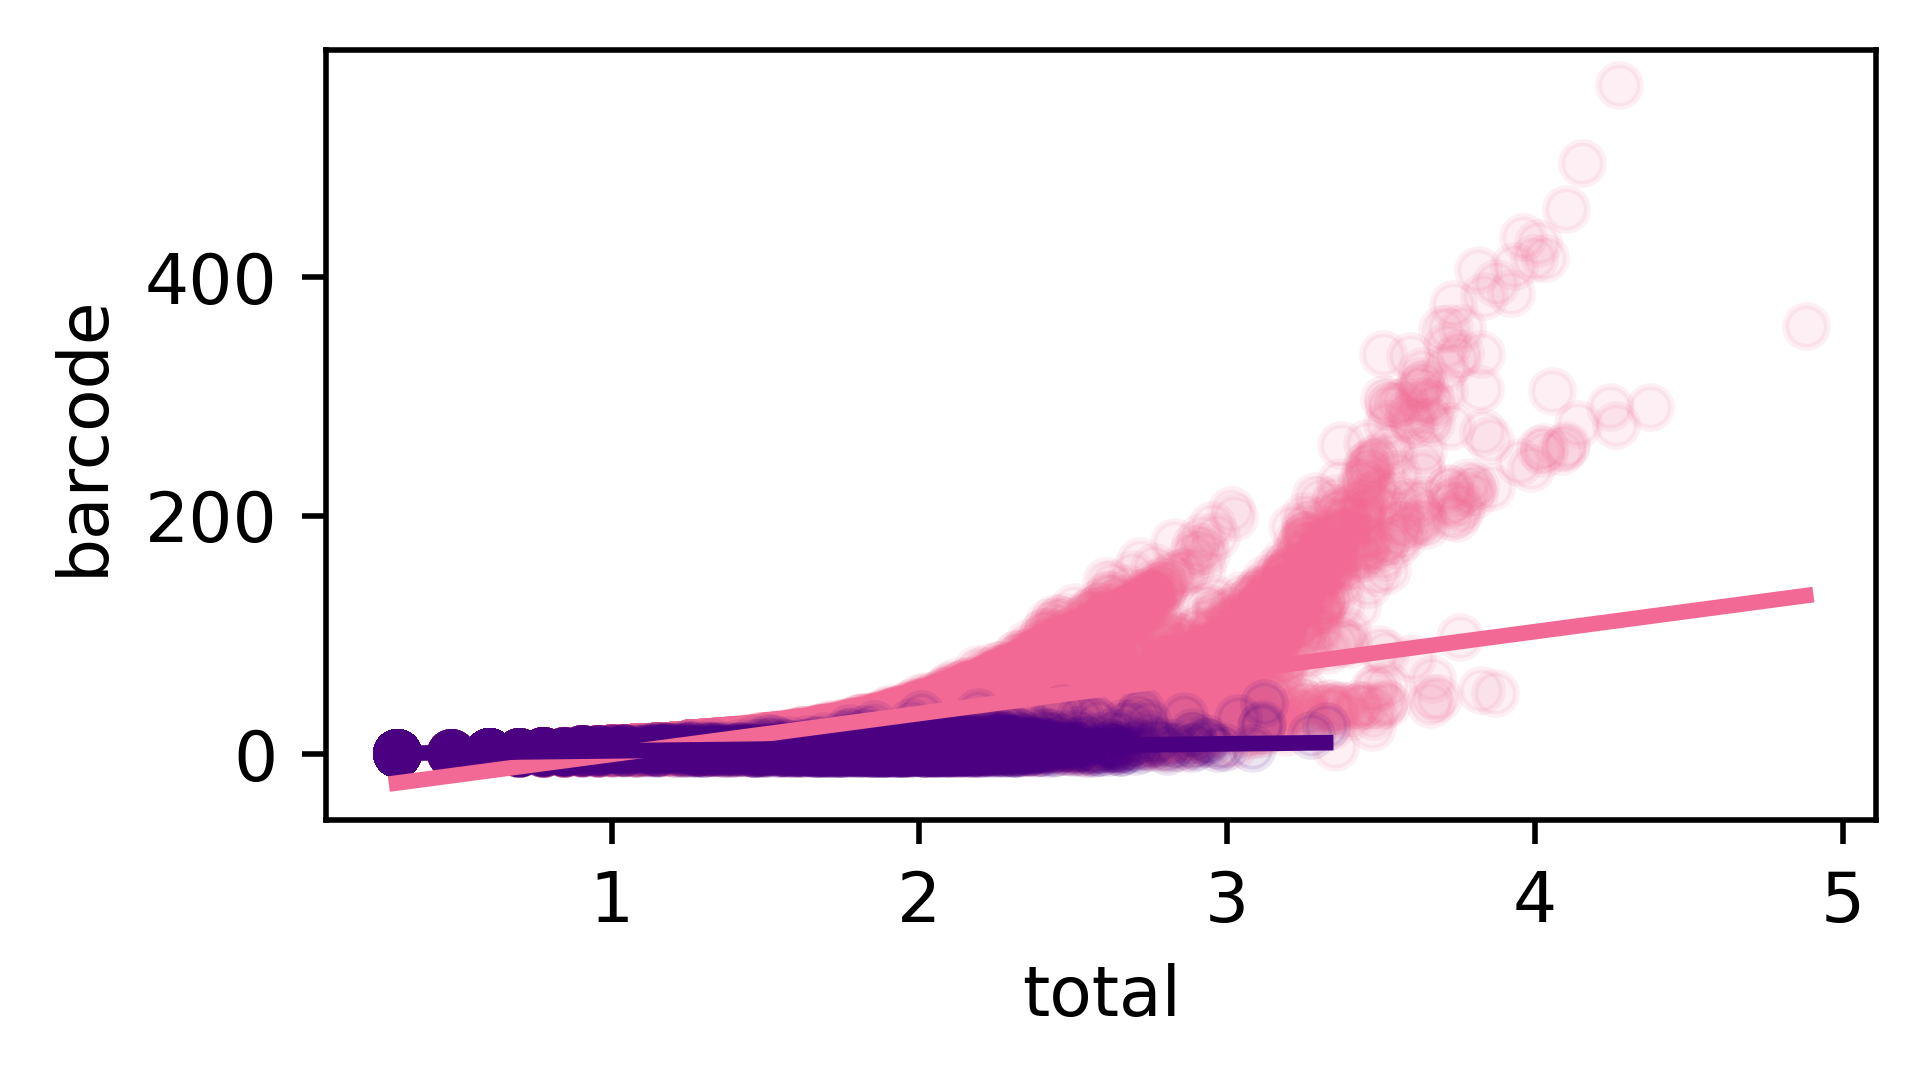

In [53]:
from matplotlib.pyplot import figure

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

figure(figsize=(4, 2), dpi=500)

sns.regplot(data=real_mergeddf, x='total', y='barcode', color = '#f16994',scatter_kws={'alpha':0.1})
ax=sns.regplot(data=nog_mergeddf, x='total', y='barcode', color = 'indigo',scatter_kws={'alpha':0.1})

ax.figure.savefig("../figs/sfig_conn/nog_total_bc.pdf")

### No G vs. F

In [37]:
# barcode frequency vs. cells with barcodes per dataset
c1_counts=real_exp.loc[real_exp['datasetid'] == 'c1']
c2_counts=real_exp.loc[real_exp['datasetid'] == 'c2']
c3_counts=real_exp.loc[real_exp['datasetid'] == 'c3']
c4_counts=real_exp.loc[real_exp['datasetid'] == 'c4']

n1_counts=real_exp.loc[real_exp['datasetid'] == 'n1']
n2_counts=real_exp.loc[real_exp['datasetid'] == 'n2']
n3_counts=real_exp.loc[real_exp['datasetid'] == 'n3']
n4_counts=real_exp.loc[real_exp['datasetid'] == 'n4']

In [38]:
#Standardize barcode naming scheme by dropping slice ID from the front
c1_counts['barcode'] = c1_counts['barcode'].str[3:]
c2_counts['barcode'] = c2_counts['barcode'].str[3:]
c3_counts['barcode'] = c3_counts['barcode'].str[3:]
c4_counts['barcode'] = c4_counts['barcode'].str[3:]

n1_counts['barcode'] = n1_counts['barcode'].str[3:]
n2_counts['barcode'] = n2_counts['barcode'].str[3:]
n3_counts['barcode'] = n3_counts['barcode'].str[3:]
n4_counts['barcode'] = n4_counts['barcode'].str[3:]

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_78776/203715217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c1_counts['barcode'] = c1_counts['barcode'].str[3:]
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_78776/203715217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c2_counts['barcode'] = c2_counts['barcode'].str[3:]
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_78776/203715217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [39]:
nog1_counts= real_bc_1[real_bc_1.UMI_Count > 1]
nog2_counts= real_bc_2[real_bc_2.UMI_Count > 1]

In [40]:
c1_cells_per_bc=pd.DataFrame(c1_counts.groupby('barcode')['CBC'].nunique())
c2_cells_per_bc=pd.DataFrame(c2_counts.groupby('barcode')['CBC'].nunique())
c3_cells_per_bc=pd.DataFrame(c3_counts.groupby('barcode')['CBC'].nunique())
c4_cells_per_bc=pd.DataFrame(c4_counts.groupby('barcode')['CBC'].nunique())

n1_cells_per_bc=pd.DataFrame(n1_counts.groupby('barcode')['CBC'].nunique())
n2_cells_per_bc=pd.DataFrame(n2_counts.groupby('barcode')['CBC'].nunique())
n3_cells_per_bc=pd.DataFrame(n3_counts.groupby('barcode')['CBC'].nunique())
n4_cells_per_bc=pd.DataFrame(n4_counts.groupby('barcode')['CBC'].nunique())

nog1_cells_per_bc=pd.DataFrame(nog1_counts.groupby('barcode')['CBC'].nunique())
nog2_cells_per_bc=pd.DataFrame(nog2_counts.groupby('barcode')['CBC'].nunique())

In [41]:
#Map viral frequencies (f) to no g and real experimental datasets
datasetlist=[c1_cells_per_bc,
            c2_cells_per_bc,
            c3_cells_per_bc,
            c4_cells_per_bc,
            n1_cells_per_bc,
            n2_cells_per_bc,
            n3_cells_per_bc,
            n4_cells_per_bc,
            nog1_cells_per_bc,
            nog2_cells_per_bc]

for i in datasetlist:
    i['barcode']=i.index
    i['viral_frequency'] = i['barcode'].map(mar2024_cvs.set_index('original_barcode')['%UMI'])


In [42]:
#Concatenate real slices and no g experiments
real_slices=pd.concat([c1_cells_per_bc,
            c2_cells_per_bc,
            c3_cells_per_bc,
            c4_cells_per_bc,
            n1_cells_per_bc,
            n2_cells_per_bc,
            n3_cells_per_bc,
            n4_cells_per_bc])

no_g=pd.concat([nog1_cells_per_bc,
            nog2_cells_per_bc])

real_slices

,CBC,barcode,viral_frequency
barcode,,,
AATTCAAACCCCTGGCGATGG-GATCCAGCACGGCTGTTAGG-CTAGTGTCGCAACCTTGGCC,2,AATTCAAACCCCTGGCGATGG-GATCCAGCACGGCTGTTAGG-CTA...,0.000016
AATTCAAACCCCTGGCGATGG-GATCCCTGAGCTCAGAAGCG-CTAGGTTGCTCCGGGGACAC,3,AATTCAAACCCCTGGCGATGG-GATCCCTGAGCTCAGAAGCG-CTA...,0.000764
AATTCAAACCCCTGGCGATGG-GATCCTCGTTGTGGTGCAAG-CTAGCTGGAGTCTGGATGAC,4,AATTCAAACCCCTGGCGATGG-GATCCTCGTTGTGGTGCAAG-CTA...,0.000032
AATTCAAACCCCTGGCGATGG-GATCGGCGGGACGCATCTCG-CTAGGGAGGTTACTCGTGAC,8,AATTCAAACCCCTGGCGATGG-GATCGGCGGGACGCATCTCG-CTA...,0.012177
AATTCAAACCCCTGGCGATGG-GATCTGTTGGCGCCAGAGAG-CTAGACCTGACAGGCGAACC,26,AATTCAAACCCCTGGCGATGG-GATCTGTTGGCGCCAGAGAG-CTA...,0.000049
...,...,...,...
AATTCTTTTGGTGCGAGCCTG-GATCACCATGTCCAGTGCCG-CTAGAGTACTGGCGGATGAC,1,AATTCTTTTGGTGCGAGCCTG-GATCACCATGTCCAGTGCCG-CTA...,0.000079
AATTCTTTTGGTGCGAGCCTG-GATCTACCAGAACTGCCCTG-CTAGTGCCCTGCGCTTCTGC,1,AATTCTTTTGGTGCGAGCCTG-GATCTACCAGAACTGCCCTG-CTA...,0.001125
AATTCTTTTGGTGCGAGCCTG-GATCTAGGCGCCACGCGTAG-CTAGGGTTCCCGTTGATGAC,1,AATTCTTTTGGTGCGAGCCTG-GATCTAGGCGCCACGCGTAG-CTA...,0.001689


In [43]:
#For barcodes that don't appear in viral diversity libraries, apply lowest viral_frequency score
lowest_frequency=mar2024_cvs['%UMI'].min()
lowest_frequency

real_slices['viral_frequency']=real_slices['viral_frequency'].fillna(value=lowest_frequency)
real_slices

no_g['viral_frequency']=no_g['viral_frequency'].fillna(value=lowest_frequency)
no_g

,CBC,barcode,viral_frequency
barcode,,,
AATTCAAACCCCTGGCGATGG-GATCCAAATGGTGCCGCTCG-CTAGCTGTCCCACGCTTACC,1,AATTCAAACCCCTGGCGATGG-GATCCAAATGGTGCCGCTCG-CTA...,0.000627
AATTCAAACCCCTGGCGATGG-GATCGCCTTCACGTGCATTG-CTAGGCTCCCCAATACCAGC,1,AATTCAAACCCCTGGCGATGG-GATCGCCTTCACGTGCATTG-CTA...,0.000469
AATTCAAACCCCTGGCGATGG-GATCGGGTGAGCACGTAGGG-CTAGGATTACGACGGCGGGC,1,AATTCAAACCCCTGGCGATGG-GATCGGGTGAGCACGTAGGG-CTA...,0.000036
AATTCAAACCCCTGGCGATGG-GATCTCTCGGAGCCGGGTAG-CTAGGATGCGCATCGTGGCC,1,AATTCAAACCCCTGGCGATGG-GATCTCTCGGAGCCGGGTAG-CTA...,0.002980
AATTCAACAGCCCTCTACACG-GATCGGTGACTGGGGTGGGG-CTAGCCCCTTGCCGCTCATC,1,AATTCAACAGCCCTCTACACG-GATCGGTGACTGGGGTGGGG-CTA...,0.007401
...,...,...,...
AATTCTTTTGGTGCGAGCCTG-GATCGGGTGGAGTAAGGGAG-CTAGTCGTGGCGATTTGACC,1,AATTCTTTTGGTGCGAGCCTG-GATCGGGTGGAGTAAGGGAG-CTA...,0.001226
AATTCTTTTGGTGCGAGCCTG-GATCGTTGCTTCCGCGCATG-CTAGCCCATCCCCTCCATAC,1,AATTCTTTTGGTGCGAGCCTG-GATCGTTGCTTCCGCGCATG-CTA...,0.002368
AATTCTTTTGGTGCGAGCCTG-GATCTACGTGTCGTACGGTG-CTAGCCAAAGACCAGGTTGC,1,AATTCTTTTGGTGCGAGCCTG-GATCTACGTGTCGTACGGTG-CTA...,0.000001


In [44]:
no_g['logged_CBC']=np.log10(no_g['CBC'])
real_slices['logged_CBC']=np.log10(real_slices['CBC'])

no_g['logged_frequency']=np.log10(no_g['viral_frequency'])
real_slices['logged_frequency']=np.log10(real_slices['viral_frequency'])

In [45]:
figure(figsize=(4, 2), dpi=500)

sns.regplot(data=real_slices, x='logged_frequency', y='logged_CBC', color = '#f16994',scatter_kws={'alpha':0.1})
ax=sns.regplot(data=no_g, x='logged_frequency', y='logged_CBC', color = 'indigo',scatter_kws={'alpha':0.1})

#ax.figure.savefig("../figs/sfig_conn/umi_thresholded_f_vs_cells_infected.png")#

NameError: name 'figure' is not defined

In [68]:
corr_matrix = np.corrcoef(real_slices['logged_frequency'], real_slices['logged_CBC'])
print(stats.spearmanr(real_slices['logged_frequency'], real_slices['logged_CBC'],nan_policy="omit"))
corr = corr_matrix[0,1]
R_sq = corr**2
print('Real slices r_squared:')
print(R_sq)
print()

corr_matrix = np.corrcoef(no_g['logged_frequency'], no_g['logged_CBC'])
print(stats.spearmanr(no_g['logged_frequency'], no_g['logged_CBC'],nan_policy="omit"))
corr = corr_matrix[0,1]
R_sq = corr**2
print('No G r_squared:')
print(R_sq)

SignificanceResult(statistic=0.03131214426247889, pvalue=1.103193336726062e-05)
Real slices r_squared:
0.000559849199319503

SignificanceResult(statistic=0.09858359223714176, pvalue=3.026744245993777e-19)
No G r_squared:
0.006638793803126474


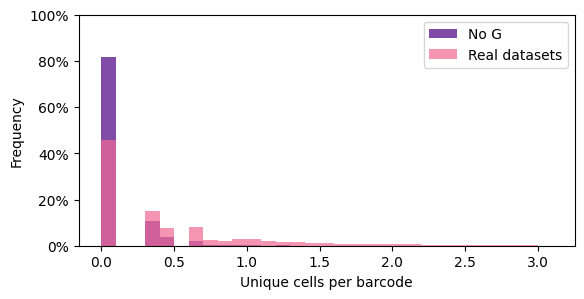

In [46]:
plt.figure().set_figheight(3)
from matplotlib.ticker import PercentFormatter
plt.hist(no_g['logged_CBC'],bins=np.arange(0,no_g['logged_CBC'].max() + 0.1, 0.1),color='indigo',alpha=0.7,label='No G',weights=np.ones(len(no_g['logged_CBC'])) / len(no_g['logged_CBC']))
plt.hist(real_slices['logged_CBC'],bins=np.arange(0, real_slices['logged_CBC'].max() + 0.1, 0.1),color='#f16994',alpha=0.7,label='Real datasets',weights=np.ones(len(real_slices['logged_CBC'])) / len(real_slices['logged_CBC']))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Unique cells per barcode')
plt.ylabel('Frequency')
#plt.xlim([-1, 100])
plt.ylim([0,1])
#plt.yscale('log')
plt.legend()
#plt.title('UMIs per Barcode:CBC Combo')
#plt.savefig('../figs/sfig_conn/no_g_unique_bcs.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
# Box and whisker w/ thresholding

In [116]:
s1_counts=real_exp.loc[real_exp['datasetid'] == 's1']
s2_counts=real_exp.loc[real_exp['datasetid'] == 's2']
s3_counts=real_exp.loc[real_exp['datasetid'] == 's3']
s4_counts=real_exp.loc[real_exp['datasetid'] == 's4']
s5_counts=real_exp.loc[real_exp['datasetid'] == 's5']

s1_unique=make_unique_table(s1_counts,'s1')
s2_unique=make_unique_table(s2_counts,'s2')
s3_unique=make_unique_table(s3_counts,'s3')
s4_unique=make_unique_table(s4_counts,'s4')
s5_unique=make_unique_table(s5_counts,'s5')

c1_unique=make_unique_table(c1_counts,'c1')
c2_unique=make_unique_table(c2_counts,'c2')
c3_unique=make_unique_table(c3_counts,'c3')
c4_unique=make_unique_table(c4_counts,'c4')

n1_unique=make_unique_table(n1_counts,'n1')
n2_unique=make_unique_table(n2_counts,'n2')
n3_unique=make_unique_table(n3_counts,'n3')
n4_unique=make_unique_table(n4_counts,'n4')


downsampled_empty_nuc= downsampled_empty_nuc[downsampled_empty_nuc.UMI_Count > 1]
empty_nuc_unique=make_unique_table(downsampled_empty_nuc,'empty_nuc')

downsampled_empty_cell= downsampled_empty_cell[downsampled_empty_cell.UMI_Count > 1]
empty_cell_unique=make_unique_table(downsampled_empty_cell,'empty_cell')


nog1_unique=make_unique_table(nog1_counts,'no_g')
nog2_unique=make_unique_table(nog2_counts,'no_g')

hek=pd.concat([hek_1,
               hek_2,
               hek_3,
               hek_4,
               hek_5,
               hek_6,
               hek_7,
               hek_8,
               hek_9,
               hek_10,
               hek_11,
               hek_12,
               hek_13,
               hek_14,
               hek_15,
               hek_16
              ])

hek= hek[hek.UMI_Count > 1]

uhek=pd.concat([uhek_1,
               uhek_2,
               uhek_3,
               uhek_4,
               uhek_5,
               uhek_6,
               uhek_7,
               uhek_8
              ])

uhek= uhek[uhek.UMI_Count > 1]
              
hek_unique=make_unique_table(hek,'hek')
uhek_unique=make_unique_table(uhek,'uhek')            

In [117]:
#Concatenate all dataframes together for input into box and whisker plot
box_input=pd.concat([s1_unique,
                     s2_unique,
                     s3_unique,
                     s4_unique,
                     s5_unique,
                     c1_unique,
                     c2_unique,
                     c3_unique,
                     c4_unique,
                     n1_unique,
                     n2_unique,
                     n3_unique,
                     n4_unique,
                     nog1_unique,
                     nog2_unique,
                     empty_nuc_unique,
                     empty_cell_unique,
                     hek_unique,
                     uhek_unique
                    ])

box_input

,barcode,datasetid
CBC,,
s1_AAAAAAGGCCTCATCA,173,s1
s1_AAAAAATGAGATAGTT,42,s1
s1_AAAAAGCGATTGAGCA,211,s1
s1_AAAAAGTGAGAGACGC,57,s1
s1_AAAACCAGAGGTATTA,18,s1
...,...,...
hek_5,413,hek
hek_6,247,hek
hek_7,227,hek


In [118]:
box_input['logged_values']=np.log10(box_input['barcode'])
box_input

,barcode,datasetid,logged_values
CBC,,,
s1_AAAAAAGGCCTCATCA,173,s1,2.238046
s1_AAAAAATGAGATAGTT,42,s1,1.623249
s1_AAAAAGCGATTGAGCA,211,s1,2.324282
s1_AAAAAGTGAGAGACGC,57,s1,1.755875
s1_AAAACCAGAGGTATTA,18,s1,1.255273
...,...,...,...
hek_5,413,hek,2.615950
hek_6,247,hek,2.392697
hek_7,227,hek,2.356026


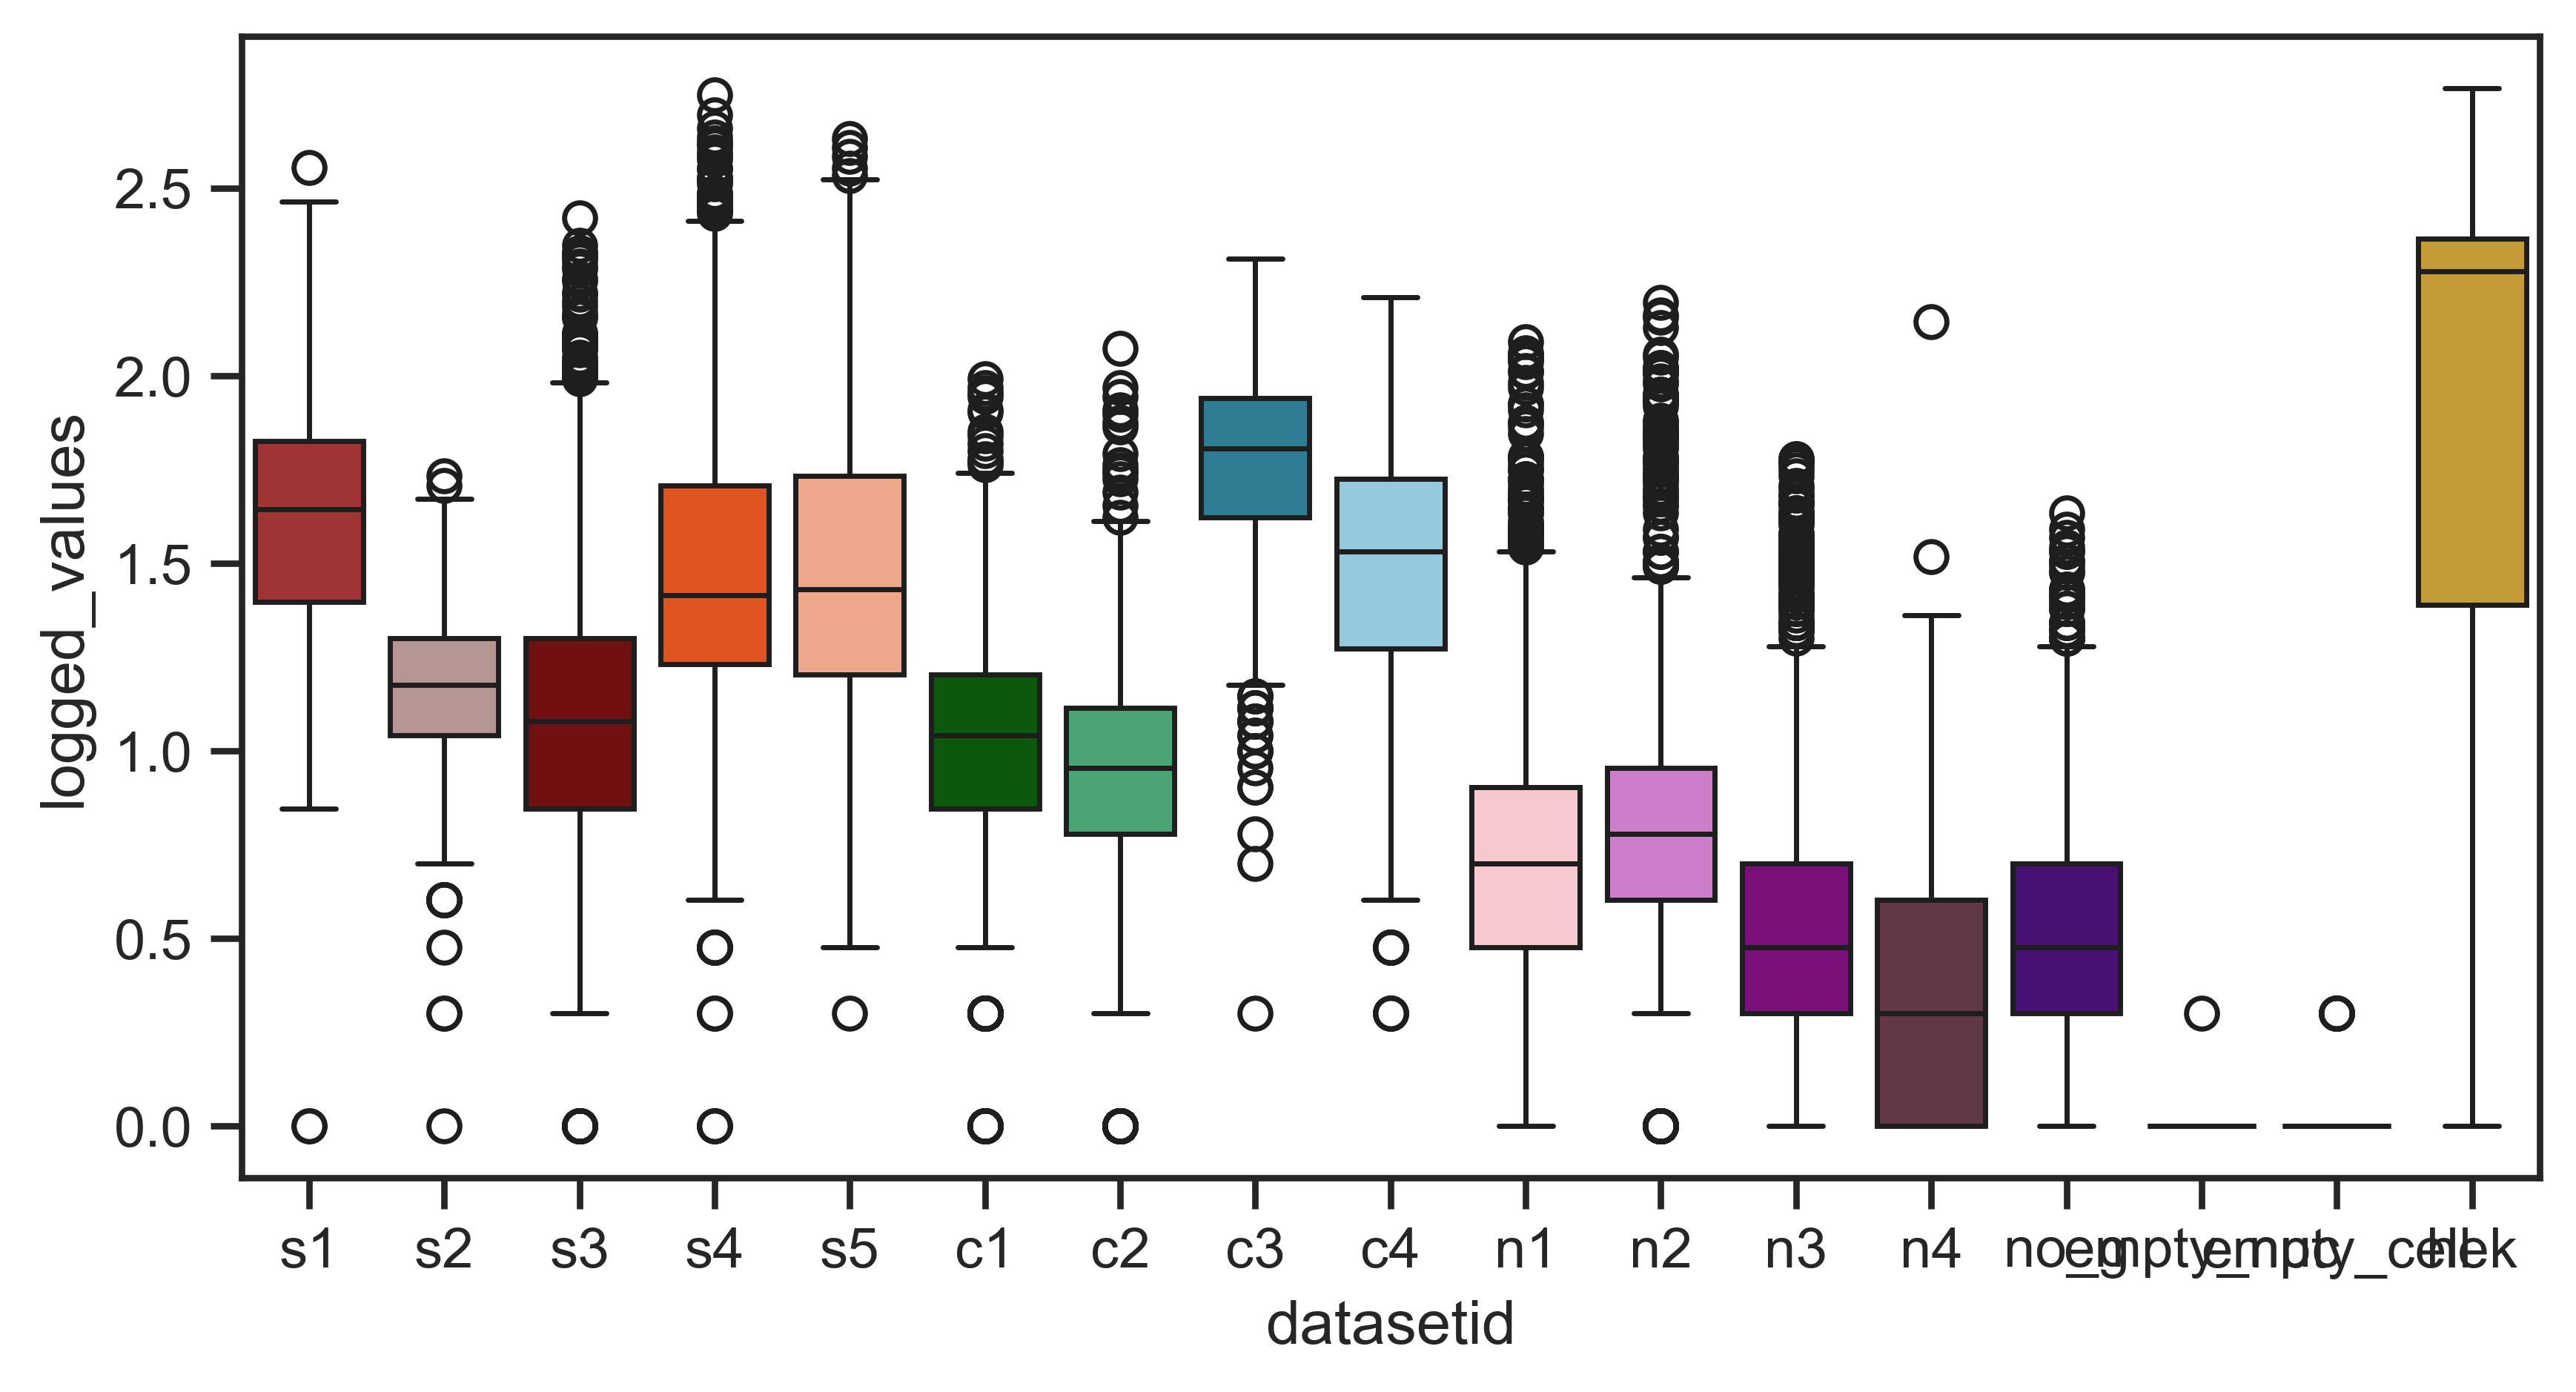

In [83]:
from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=500)


custom_params = {"axes.spines.right": True, "axes.spines.top": True}

sns.set_theme(context='notebook', style='ticks', palette='deep', font='arial', font_scale=1, color_codes=True, rc=custom_params)
palette = ["#b22222","#bc8f8f",'#800000','#ff4500','#ffa07a',
           '#006400','#3cb371','#1d87a3','#87ceeb',
           '#ffc0cb','#da70d6','#8b008b','#673147',
          'indigo',
          '#5f668e','#816482',
          'goldenrod','grey']
sns.set_palette(palette)
sns.boxplot(data=box_input, x="datasetid", y="logged_values", hue="datasetid")
ax.tick_params(axis='x', labelrotation=45)
plt.legend([],[], frameon=False)
plt.savefig('../figs/sfig_conn/thresholded_unique_bcs_by_dataset.pdf', bbox_inches='tight', format='pdf')

In [119]:
cell=pd.concat([s1_unique,
                s2_unique,
                s3_unique,
                s4_unique,
                s5_unique,
                c1_unique,
                c2_unique,
                c3_unique,
                c4_unique])
nuc=pd.concat([n1_unique,
                n2_unique,
                n3_unique,
                n4_unique])
nuc

,barcode,datasetid
CBC,,
n1_AAAAAAATATGTAGCC,1,n1
n1_AAAAAATACCAAAATG,6,n1
n1_AAAAAATCCCTGAGAA,6,n1
n1_AAAAAATGAGGCAATG,6,n1
n1_AAAAAATGATGGAGCA,5,n1
...,...,...
n4_CCTTACCTCCTCCCTA,2,n4
n4_CCTTACGGACAAAAGG,4,n4
n4_CCTTCAGTCACTAAGG,5,n4


In [120]:
print(nuc['barcode'].median())
print(nuc['barcode'].mean())

print(cell['barcode'].median())
print(cell['barcode'].mean())

4.0
6.731842737094838
13.0
22.843970934799685


In [123]:
real_exp['barcode'].nunique()

22670

In [132]:
nog1_counts['barcode'].nunique()

1137

In [133]:
nog2_counts['barcode'].nunique()

7100

In [125]:
temp=no_g[no_g['datasetid'].isin(['c1','c2','c3','c4','n1','n2','n3','n4'])]
temp['barcode'].nunique()

8132

In [129]:
temp=real_exp[real_exp['datasetid'].isin(['c1','c2','c3','c4','n1','n2','n3','n4'])]
temp['barcode'].nunique()

19702

In [135]:
print(nog1_counts['CBC'].nunique())
print(nog2_counts['CBC'].nunique())

548
2332
